In [350]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [351]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [352]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DSA_features.csv')

In [353]:
# 'sitting'과 'jumping' 활동만 필터링하여 사용
# 이 두 가지 활동만 분석 대상으로 하여 'label' 열을 추가함
df_filtered = df[df['activity'].isin(['sitting', 'jumping'])]
df_filtered['label'] = df_filtered['activity'].apply(lambda x: 'normal' if x == 'sitting' else 'abnormal')

<ipython-input-353-d26c1c8960c2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['label'] = df_filtered['activity'].apply(lambda x: 'normal' if x == 'sitting' else 'abnormal')


In [354]:
# 독립 변수와 종속 변수 분리
# 'activity'와 'label' 열을 제외한 나머지 열들을 입력 데이터로 사용하고, 원-핫 인코딩을 적용
x_data = pd.get_dummies(df_filtered.drop(columns=['activity', 'label'])).values.astype('float32')

# 'label' 열을 예측 대상 데이터로 사용
y_data = df_filtered['label'].values

In [355]:
# 학습 및 테스트 데이터 분할 (80% 학습, 20% 테스트)
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

# 학습 데이터를 다시 훈련 데이터와 검증 데이터로 분할 (80% 학습, 20% 검증)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.2, random_state=42)

In [356]:
# 'sitting' 데이터를 정상 데이터로 사용하기 위해 정상 데이터만 분리
train_x_normal = train_x[train_y == 'normal']
valid_x_normal = valid_x[valid_y == 'normal']

In [357]:
# 데이터 정규화 - 평균 0, 분산 1로 표준화
scaler = StandardScaler()
train_x_normal = scaler.fit_transform(train_x_normal)
valid_x_normal = scaler.transform(valid_x_normal)
test_x = scaler.transform(test_x)

In [358]:
# 오토인코더 모델 정의
# 입력 차원 정의 (입력 데이터의 열 개수)
input_dim = train_x_normal.shape[1]
encoding_dim = 14

In [359]:
# 오토인코더의 입력 레이어와 인코딩/디코딩 레이어 구성
input_layer = Input(shape=(input_dim,))
# 인코딩 레이어 1: 입력 데이터를 잠재 공간으로 압축하는 과정
# 첫 번째 인코딩 레이어는 'relu' 활성화 함수를 사용하여 입력을 encoding_dim 차원으로 줄임
encoded = Dense(encoding_dim, activation='relu')(input_layer)
# 인코딩 레이어 2: 잠재 공간의 차원을 더 줄여서 중요한 특징만 남김
# encoding_dim의 절반 크기로 줄이며 'relu' 활성화 함수를 사용함
encoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
# 디코딩 레이어 1: 인코딩된 잠재 공간을 다시 복원하는 과정 시작
# 인코딩 레이어의 크기와 동일한 차원으로 복원하며 'relu' 활성화 함수를 사용함
decoded = Dense(int(encoding_dim / 2), activation='relu')(encoded)
# 디코딩 레이어 2: 원래 입력 차원으로 복원
# 출력 레이어는 입력과 동일한 차원을 가지며, 'sigmoid' 활성화 함수를 사용하여 각 값이 0과 1 사이에 있도록 함
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 오토인코더 모델 정의 및 컴파일
# 손실 함수로 평균 제곱 오차(mse)를 사용하고 Adam 옵티마이저로 학습
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [360]:
# 데이터 다시 정규화
train_x_normal = scaler.fit_transform(train_x_normal)
valid_x_normal = scaler.transform(valid_x_normal)
test_x = scaler.transform(test_x)

In [361]:
# 오토인코더 모델 학습
# 정상 데이터로만 학습하여 정상 패턴을 학습
history = autoencoder.fit(train_x_normal, train_x_normal,
                          epochs=50,
                          batch_size=32,
                          shuffle=True,
                          validation_data=(valid_x_normal, valid_x_normal))

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 1.2030 - val_loss: 93.9288
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1505 - val_loss: 93.9265
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2087 - val_loss: 93.9170
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.1221 - val_loss: 93.9028
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.3136 - val_loss: 93.8877
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.9957 - val_loss: 93.8766
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0208 - val_loss: 93.8810
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1647 - val_loss: 93.8827
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9487 - val_loss: 93.8774
Epoch 10/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0294 - val_loss: 93.8608
Epoch 11/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 1.0533 - val_loss: 93.8386
Epoch 12/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - lo

In [362]:
# 테스트 데이터에 대한 재구성
reconstructed = autoencoder.predict(test_x)
# 재구성 오차 계산
reconstruction_error = np.mean(np.power(test_x - reconstructed, 2), axis=1)

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [363]:
# 재구성 오차의 임계값 설정 (41번째 백분위수 사용)
# 이 임계값을 기준으로 이상 여부를 판별
threshold = np.percentile(reconstruction_error, 41)
# 재구성 오차가 임계값을 초과하면 'abnormal', 그렇지 않으면 'normal'로 예측
y_pred = ['abnormal' if error > threshold else 'normal' for error in reconstruction_error]

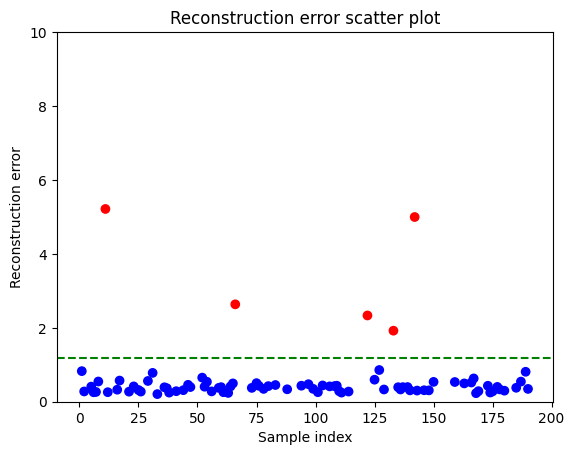

In [364]:
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=['red' if error > threshold else 'blue' for error in reconstruction_error])
plt.ylim([0, 10])  # y축 범위를 0에서 10으로 설정하여 대부분의 데이터를 더 잘 보이게 함
plt.axhline(y=threshold, color='green', linestyle='--')
plt.xlabel('Sample index')
plt.ylabel('Reconstruction error')
plt.title('Reconstruction error scatter plot')
plt.show()


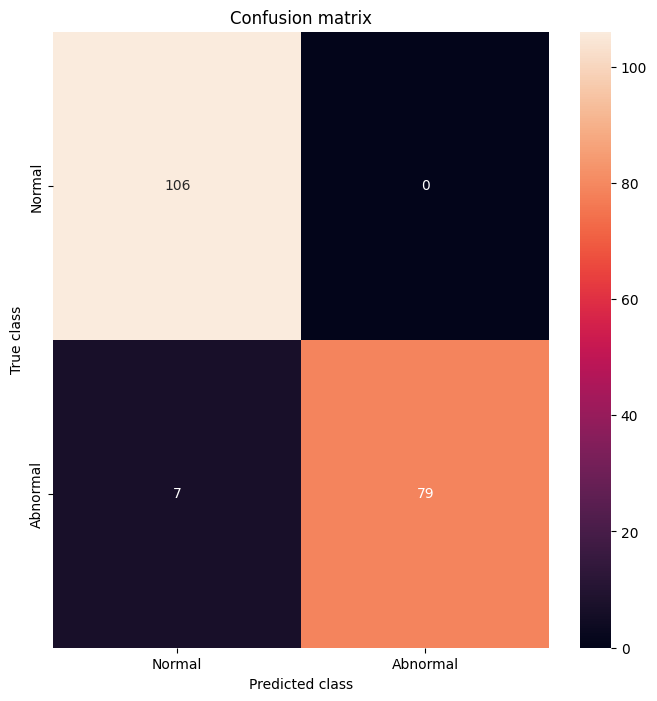

              precision    recall  f1-score   support

    abnormal       0.94      1.00      0.97       106
      normal       1.00      0.92      0.96        86

    accuracy                           0.96       192
   macro avg       0.97      0.96      0.96       192
weighted avg       0.97      0.96      0.96       192



In [365]:
conf_matrix = confusion_matrix(test_y, y_pred)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, xticklabels=['Normal', 'Abnormal'], yticklabels=['Normal', 'Abnormal'], annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

print(classification_report(test_y, y_pred))
